In [64]:
print("a")

a


In [65]:
import importlib
import imageio.v2 as imageio
from patient import patient
import glob

# https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/6ACUZJ

In [66]:
import importlib
import imageio.v2 as imageio
from patient import patient
import glob

# https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/6ACUZJ

from tqdm.notebook import tqdm
for vol_path in tqdm(glob.glob("./data/*")):
    if "__" in vol_path:
        continue
    vol = vol_path.split("/")[-1]
    print(vol)
    # print(vol)
    p = patient.patient(name=vol)
# imageio.mimsave(f"pics/drr.gif", p.drr.img)

  0%|          | 0/107 [00:00<?, ?it/s]

4411403
4411398
4411433
4411396
4411471
4411564
sample1010
sample1009
4410400
sample1005
4404367
4410839
4410828
4410857
4404147
4411404
4404150
sample1002
4410827
4404149
4410824
4411566
4410856
4411408
4267535
4410837
4410832
4410829
4410835


KeyboardInterrupt: 

In [6]:
from patient import patient
import imageio.v2 as imageio
import cupy as cp

p = patient.patient(name="4411469")

a = 180


imageio.imsave("pics/ct.png", cp.asnumpy(p.ct.img[a]))
# imageio.imsave("pics/test2.png", p.get_resized_fbp(p.get_equiv(a, plot=True)[0]))
imageio.imsave("pics/test2.png", cp.asnumpy(p.get_equiv_fbp(a)))

imgct = imageio.imread("pics/ct.png").astype("float32")
imgrec = imageio.imread("pics/test2.png").astype("float32")

imageio.imsave("pics/diff.png", imgct - imgrec)

IndexError: Index 1 is out of bounds for axis 0 with size 0

In [1]:
import imageio.v2 as imageio
from patient import patient
import cupy as cp

a = 185
p = patient.patient(name="4410400")
# p.calculate_resize()
imageio.imsave("test3.png", cp.asnumpy(p.get_equiv_fbp(a)))
imageio.imsave("test4.png", cp.asnumpy(p.ct.img[a]))
# imageio.imsave("test3.png", cp.asnumpy(p.posfbp.get(131)))
imageio.imsave("test5.png", cp.asnumpy(p.get_equiv_fbp(a)) - cp.asnumpy(p.ct.img[a]))

Lossy conversion from float64 to uint8. Range [0.9610147906599955, 1.045815040058848]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.9246463991857992, 1.073796337428703]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.9363052899241175, 1.0672472223794813]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [10, 249]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.9610147906599955, 1.045815040058848]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.9246463991857992, 1.073796337428703]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.9363052899241175, 1.0672472223794813]. Convert image to uint8 prior to

: 

## Xray set

In [1]:
import importlib
from xray import xray
import imageio.v2 as imageio
import cv2   
import cupy as cp
import numpy as np

importlib.reload(xray)

xrayset = xray.xrayset(
        name="__phantom",
        sheets=450,
        voltage=120,
        height=1024,
        output_height=500
    )

  0%|          | 0/450 [00:00<?, ?it/s]

500 500


  0%|          | 0/61 [00:00<?, ?it/s]

In [2]:
print(xrayset.mean, xrayset.std)

202.13799876610375 28.001571358626776


170.14660365821723


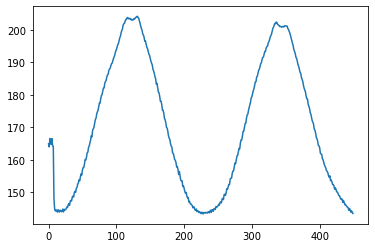

In [2]:
import matplotlib.pyplot as plt

stat = [cp.asnumpy(s) for s in xrayset.stat]
plt.plot(stat)
print(np.average(stat))

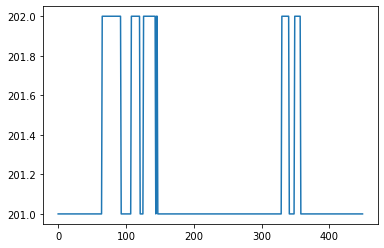

In [3]:
avg = [int(cp.average(img[img > 60])) for img in xrayset.img]
plt.plot(avg)

In [5]:
imgs = []
for img in xrayset.img:
    imgs.append(cp.asnumpy(img))
imageio.mimsave("x.gif", imgs)

In [4]:
import fbp.tompy as fbp
import cupy as cp

# fbp from xrayset
rec2 = fbp.fbpset(
        xrayset,
        height=1000,
        # adjust_alpha=4.,
        # adjust_beta=-120.,
        # angle=1,
        rotate=200,
        load_all=False
    )

# print(cp.asnumpy(rec2.get(5)))
# imageio.imsave("test.png", cp.asnumpy(rec2.get(5)))
# imageio.imsave("x.png", cp.asnumpy(rec2.x.img[200]).ravel())

(1000, 1000)


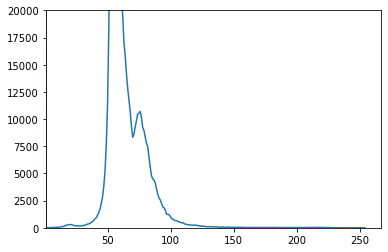

In [9]:
import matplotlib.pyplot as plt

img = cp.asnumpy(rec2.get(300)).astype("float64")
print(np.shape(img))

half = 500

# for x in range(0, len(img)):
#     for y in range(0, len(img[x])):
#         dist = np.sqrt((x - half) * (x - half) + (y - half) * (y - half))
#         # if dist > 110:
#         # img[x][y] = dist
#         i = 300
#         o = 500
#         f = -1 / (o - i) * (dist - i) + 1
#         f = np.minimum(f, 1)
#         f = np.maximum(f, 0)
#         img[x][y] *= f

# for x in range(0, len(img)):
#     for y in range(0, len(img[x])):
#         dist = np.sqrt((x - half) * (x - half) + (y - half) * (y - half))
#         # if dist > 110:
#         # img[x][y] = dist
#         i = 320
#         o = 340
#         f = -1 / (o - i) * (dist - i) + 1
#         f = np.minimum(f, 1)
#         f = np.maximum(f, 0)
#         img[x][y] *= f

# for x in range(0, len(img)):
#     for y in range(0, len(img[x])):
#         dist = np.sqrt((x - half) * (x - half) + (y - half) * (y - half))
#         # if dist > 110:
#         # img[x][y] = dist
#         i = 250
#         o = 550
#         f = -1 / (o - i) * (dist - i) + 1
#         f = np.minimum(f, 1)
#         f = np.maximum(f, 0)
#         img[x][y] *= f

loVal = 0
hiVal = 255

img = ((img - loVal) * 255.0 / (hiVal - loVal))
img[img < 0] = 0
img[img > 255] = 255

img = img.astype("uint8")

histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))
plt.plot(bin_edges[0:-1], histogram)
plt.xlim(1)
plt.ylim(0, 20000)

imageio.imsave("test1.png", img.astype("uint8"))

In [8]:
import numpy as np
from skimage import io
from sklearn.cluster import KMeans

# original = io.imread('https://i.stack.imgur.com/QCl8D.jpg')
original = img
n_colors = 6

arr = original.reshape((-1, 3))
kmeans = KMeans(n_clusters=n_colors, random_state=42).fit(arr)
labels = kmeans.labels_
centers = kmeans.cluster_centers_
less_colors = centers[labels].reshape(original.shape).astype('uint8')

io.imshow(less_colors)

ValueError: cannot reshape array of size 1000000 into shape (3)

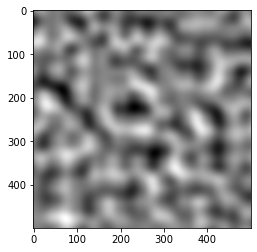

In [36]:
import matplotlib.pyplot as plt
from perlin_noise import PerlinNoise

noise = PerlinNoise(octaves=10, seed=1)
xpix, ypix = 500, 500
pic = [[noise([i/xpix, j/ypix]) for j in range(xpix)] for i in range(ypix)]

plt.imshow(pic, cmap='gray')
plt.show()